In [1]:
from functions.model import default_model

model = default_model()

2021-12-16 12:54:12.276420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 12:54:12.286736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 12:54:12.287355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 12:54:12.288398: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
from functions.data import block_size, SatelliteData

dataset = SatelliteData(satellite_path="./data/crs-china.tiff", land_coverage_path="./data/E100N40_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif")
step_size = block_size // 2

In [3]:
from functions.image import get_training_img
import numpy as np
from matplotlib import pyplot as plt


def coord_to_image(coord):
    return get_training_img(coord, block_size, dataset.satellite_image(), dataset.satellite())


def mark_tile(xx, yy, img, highlight):
    img[xx - block_size // 2:xx + block_size // 2, yy - block_size // 2] = highlight
    img[xx - block_size // 2:xx + block_size // 2, yy + block_size // 2] = highlight
    img[xx - block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight
    img[xx + block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight


def plot_windmills(left_top_coord, size=(1200, 800), intensity=1):
    (img_h, img_w) = size
    left_top_x, left_top_y = dataset.satellite().index(left_top_coord[0], left_top_coord[1])
    needles = []

    for xx in range(left_top_x + block_size // 2, left_top_x + img_w - block_size // 2, step_size):
        for yy in range(left_top_y + block_size // 2, left_top_y + img_h - block_size // 2, step_size):
            cc = dataset.satellite().transform * (yy, xx)
            lx, ly = dataset.land_coverage().index(cc[0], cc[1])
            if dataset.land_coverage_image()[lx, ly] != 1:
                continue
            needles.append((cc[0], cc[1]))

    test_images = np.stack([coord_to_image(coord) for coord in needles])
    results = model.predict(test_images)

    search_space = np.copy(dataset.satellite_image()[left_top_x:left_top_x + img_w, left_top_y:left_top_y + img_h])
    search_space = search_space ** (1 / 4)
    highlight = np.max(search_space) * 0.75 * intensity

    coords = {}

    for i, result in enumerate(results):
        if result[1] > result[0]:

            # get screen and real life coords
            coord = needles[i]
            xx, yy = dataset.satellite().index(coord[0], coord[1])
            xx -= left_top_x
            yy -= left_top_y

            # fixes approx errors
            xx = round(xx / step_size) * step_size
            yy = round(yy / step_size) * step_size

            # exclude neighbors
            if f"{xx - step_size},{yy}" in coords:
                continue
            if f"{xx},{yy - step_size}" in coords:
                continue
            if f"{xx - step_size},{yy + step_size}" in coords:
                continue
            if f"{xx - step_size},{yy - step_size}" in coords:
                continue

            mark_tile(xx, yy, search_space, highlight)
            coords[f"{xx},{yy}"] = coord

    print(f"found {len(coords)} objects")

    plt.rcParams['figure.figsize'] = [20, 10]
    plt.imshow(search_space)

    return coords.values()

2021-12-16 12:54:58.191687: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2021-12-16 12:54:58.655035: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


found 133 objects


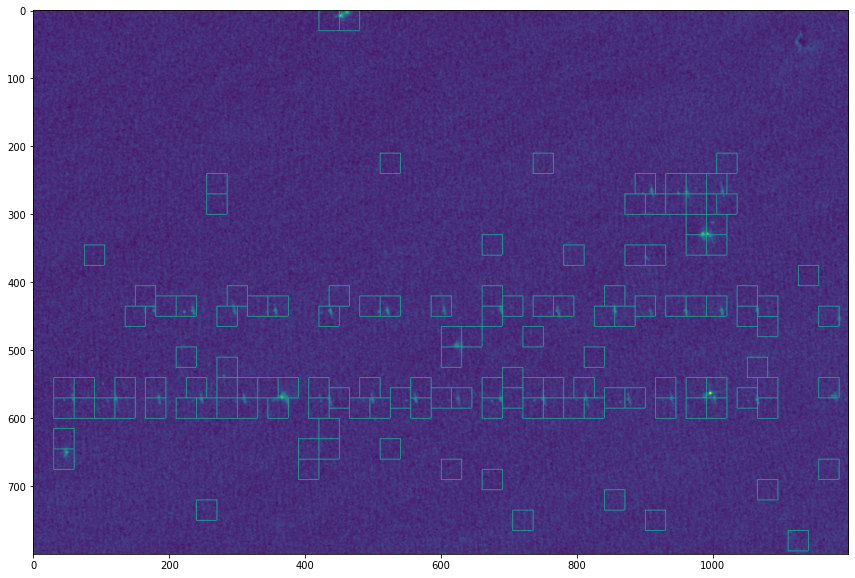

In [4]:
# vb molens
_ = plot_windmills((116.98883,23.32341))

found 98 objects


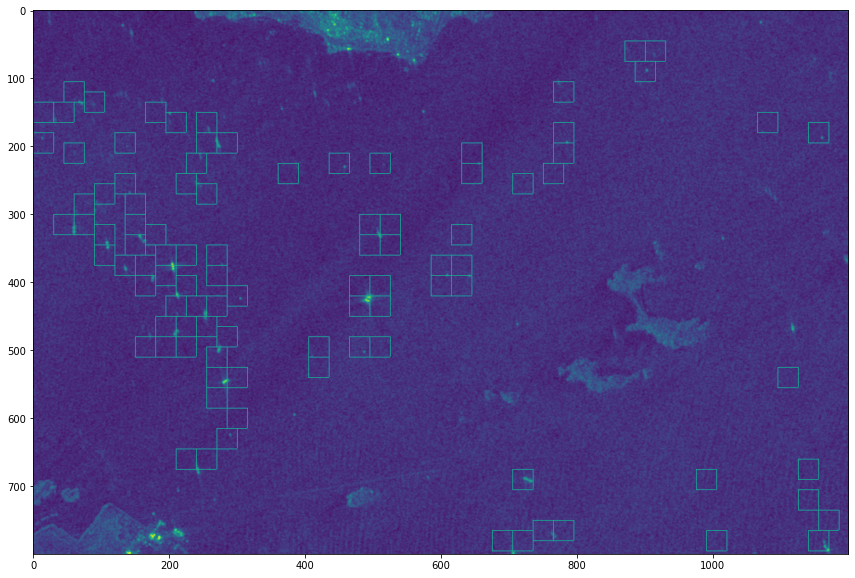

In [5]:
# vb boten
_ = plot_windmills((118.07980,24.43174))

found 26 objects


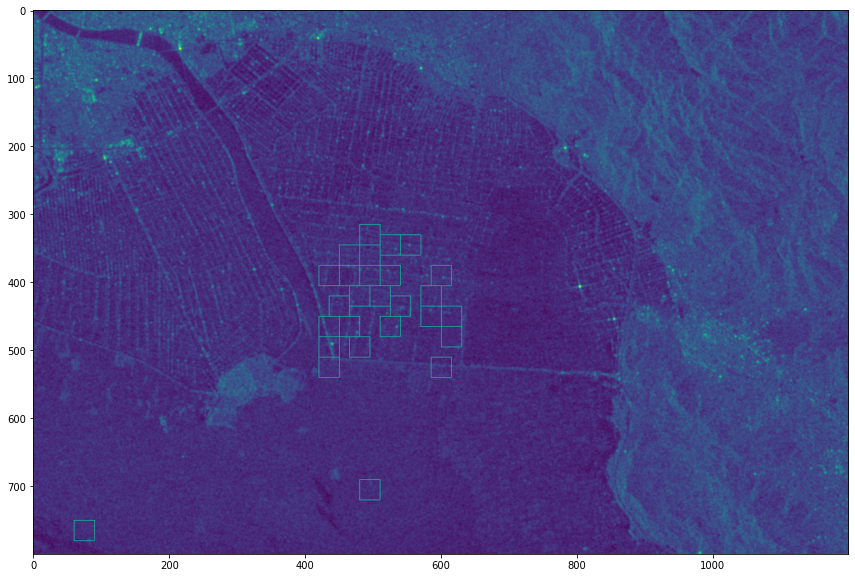

In [6]:
# vb kust
_ = plot_windmills((116.99489,23.67112))

In [7]:
def find_all():
    print("generating coordinates...")
    [h, w] = dataset.satellite().shape
    needles = []
    for xx in range(block_size // 2, h - block_size // 2, step_size):
        for yy in range(block_size // 2, w - block_size // 2, step_size):
            if dataset.satellite_image()[xx, yy] == 0:
                continue
            cc = dataset.satellite().transform * (yy, xx)
            lx, ly = dataset.land_coverage().index(cc[0], cc[1])
            if dataset.land_coverage_image()[lx, ly] != 1:
                continue
            needles.append((cc[0], cc[1]))

    print("extracting...")
    samples = []
    for i, needle in enumerate(needles):
        if i % 100000 == 0:
            print(f"{round(i / len(needles) * 100)}%")
        samples.append(coord_to_image(needle))
    print("100%")

    print("evaluating...")
    results = model.predict(np.stack(samples))

    print("filtering...")
    coords = {}
    for i, result in enumerate(results):

        if i % 100000 == 0:
            print(f"{round(i / len(results) * 100)}%")

        if result[1] > result[0]:

            coord = needles[i]
            xx, yy = dataset.satellite().index(coord[0], coord[1])

            xx = round(xx / step_size) * step_size
            yy = round(yy / step_size) * step_size

            if f"{xx - step_size},{yy}" in coords:
                continue
            if f"{xx},{yy - step_size}" in coords:
                continue
            if f"{xx - step_size},{yy + step_size}" in coords:
                continue
            if f"{xx - step_size},{yy - step_size}" in coords:
                continue

            coords[f"{xx},{yy}"] = coord
    print("100%")

    vals = list(coords.values())
    print(f"total: {len(vals)}")
    return vals

In [8]:
import json

with open("./data/coords_china.json", "w+") as f:
    f.write(json.dumps({"coords": find_all()}))

generating coordinates...
extracting...
0%
9%
19%
28%
38%
47%
57%
66%
75%
85%
94%
100%
evaluating...


2021-12-16 12:58:11.853198: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3820608000 exceeds 10% of free system memory.
2021-12-16 12:58:14.202064: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3820608000 exceeds 10% of free system memory.


filtering...
0%
9%
19%
28%
38%
47%
57%
66%
75%
85%
94%
100%
total: 12713
